In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import torch 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import yaml

In [15]:
from models.mobrecon_ds import MobRecon_DS_additional

model = MobRecon_DS_additional()

ckpt_dir = "/root/oxr_handpose_24/misc" # parent directory
pt = '30.pt'
ckpt_root = os.path.join(ckpt_dir, pt)
ckpt = torch.load(ckpt_root)
model.load_state_dict(ckpt['model_state_dict'])

model.to(device)

Load pre-trained weight: densestack.pth


MobRecon_DS_additional(
  (backbone): DenseStack_Backnone_big(
    (pre_layer): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): mobile_unit(
        (conv3x3): Sequential(
          (0): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (conv1x1): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
    )
    (thrink): Sequential(
      (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bia

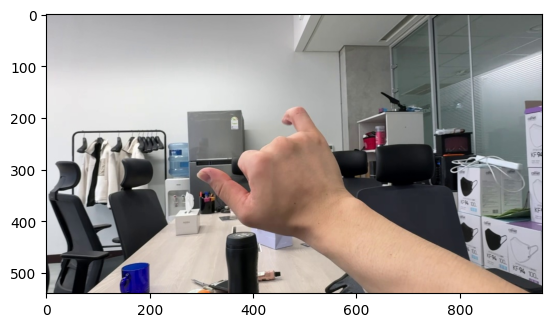

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

save_frame_path = '/root/oxr_handpose_24/misc/example_images/'
img_list = os.listdir(save_frame_path)
img_list.sort()
img_list = img_list[1:]
img_name = img_list[3]
img = Image.open(os.path.join(save_frame_path, img_name))
plt.imshow(img)

W0000 00:00:1728894413.205881   77738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728894413.245991   77768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


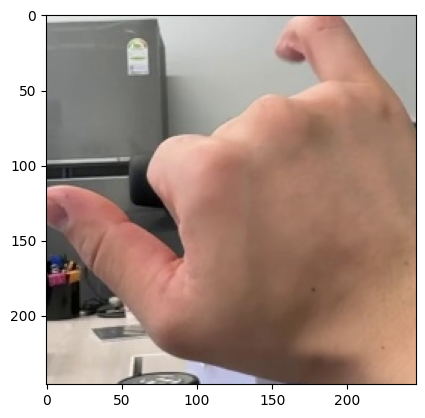

In [13]:
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    img = np.array(img)
    results = hands.process(img)

x = []
y = []
for hl in results.multi_hand_landmarks:
    land_marks = hl.landmark
    for item in land_marks:
      x.append(item.x)
      y.append(item.y)  

def get_2D_annotation(xyz, K):
    xyz = np.array(xyz) 
    K = np.array(K) 
    uv = np.matmul(K, xyz.T).T 
    return uv[:, :2] / uv[:, -1:]

# cal_2d = get_2D_annotation(item['keypoints3D'], item['K'])

y_size, x_size, _  = img.shape
# kps = item['ori_keypoints'][:,:2] # cal_2d * 128

margin = 12.

random_margin_x = int(np.random.rand() * margin)
random_margin_y = int(np.random.rand() * margin)

x_bbox = np.array(x) * x_size
y_bbox = np.array(y) * y_size

x_max = max(x_bbox) + margin # - random_margin_x, 0.)
y_max = max(y_bbox) + margin # - random_margin_y, 0.)
x_min = min(x_bbox) - margin # + random_margin_y, 256.) # x->y
y_min = min(y_bbox) - margin # + random_margin_x, 256.) # x->y
x_width =  x_max - x_min
y_height =  y_max - y_min

line_segment = max(x_width, y_height) # for square bbox
bbox = [int(x_min), int(y_min), int(line_segment), int(line_segment)]

# for i in range(21):
#     plt.plot(x[i] , y[i] , marker='o', color="blue") 
#plt.imshow(img[bbox[0]:, bbox[0]+bbox[1]:bbox[3],:])
plt.imshow(img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2], :])
# plt.imshow(img[bbox[0]:bbox[0]+bbox[2],bbox[1]:bbox[1]+bbox[3], :])


torch.Size([3, 256, 256])


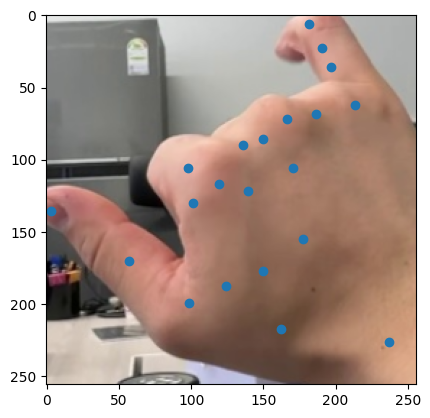

In [14]:
from torchvision import transforms

image_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize([256, 256]),
        
    ]
)

# img_tensor = torch.from_numpy(img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2], :])
img_tensor = image_transform(img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2], :])

print(img_tensor.shape)
model.eval()
with torch.no_grad():
    prev = torch.zeros(1, 21, 3).to(device) # if prev zeros -> model will not get any previous frame's information
    # prev = sth... # if prev is not zeros -> model will get previous frame's information
    output = model(img_tensor.unsqueeze(0).to(device), prev)

key_2d = output['keypoints'][0].cpu().numpy()
key_3d = output['keypoints3D'][0][:,:2].cpu().numpy()

plt.scatter(key_2d[:,0] * 256, key_2d[:,1] * 256)
plt.imshow(img_tensor.permute(1,2,0).numpy())